# EDA: Diabetes Characteristics and Dependencies

This project is an exploratory data analysis (EDA) of diabetes characteristics and dependencies, based on three different datasets from Kaggle. The aim is not to define as many criteria as possible, but to demonstrate my ability to visualize data and make conclusions based on this visualization.

The project also includes the development of complex functions for plots from different Python libraries. The focus is on the code, with examples provided for details such as dataset descriptions.

Upgraded plot methods have been prepared as separate functions to visualize data in a more convenient manner.

## Datasets

The datasets used in this project are:

1. [Diabetes Dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set): This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes. All patients here are females at least 21 years old of Pima Indian heritage.

2. [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea): This dataset is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has a 10-year risk of future coronary heart disease (CHD).

3. [Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset): The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. This dataset contains responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services.

## Author

Vladimir Vinogradov, 2024

In [70]:
# Importing necessary libraries
import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math

from typing import Any, List


### *Instruments to manage missing or abnormal data*


In [71]:
def define_zero_nan_percentage(df: pd.DataFrame, min_abn_percentage: int =25) -> None:
    """
    Calculates and prints the percentage of zeros and NaNs in each column of the given DataFrame.
    If the percentage of zeros or NaNs is greater than or equal to the specified threshold, a recommendation is printed.
    """
    zero_percentages = (df == 0).mean() * 100
    nan_percentages = df.isna().mean() * 100

    for column in df.columns:
        print(f"Column {column} has {zero_percentages[column]:.2f}% zeros and {nan_percentages[column]:.2f}% NaNs")
        if zero_percentages[column] >= min_abn_percentage or nan_percentages[column] >= min_abn_percentage:
            print(f"\033[91m      -> recommended to check expediency to drop the column {column}\033[00m")
        elif (10 >= zero_percentages[column] > 0) or (10 >= nan_percentages[column] > 0):
            print(f"\033[93m      -> recommended to check expediency to fill the column {column}\033[00m")

In [72]:
def fill_columns_with_mean(df: pd.DataFrame, cols: list[str], value_to_fill: Any, index_col: str = 'Diabetes', bins_str: str = 'Age Group') -> pd.DataFrame:
    """
    Fills the specified columns with the mean values of each bins_str based on the index_col value.
    If value_to_fill is 0, the function will replace 0 values with the mean values of each bins_str based on the index_col value.
    If value_to_fill is NaN, the function will replace NaN values with the mean values of each bins_str.
    """
    for column in cols:
        if value_to_fill == 0:
            group_mean = df[df[column] != value_to_fill].groupby([bins_str, index_col])[column].mean().reset_index().rename(columns={column: 'mean'})
            df = df.merge(group_mean, on=[bins_str, index_col], how='left')
            df.loc[df[column] == value_to_fill, column] = df['mean']
        else:  # value_to_fill is NaN
            group_mean = df[df[column].notna()].groupby(['Age Group', index_col])[column].mean().reset_index().rename(columns={column: 'mean'})
            df = df.merge(group_mean, on=[bins_str, index_col], how='left')
            df[column].fillna(df['mean'], inplace=True)
        df.drop(columns='mean', inplace=True)
    return df

### *Instruments to plot convinient diagrams for data visualization*

In [73]:
def piecharts_cockpit(df: pd.DataFrame, cols: List[str]) -> None:
    """
    Creates pie charts for the specified columns.
    Each pie chart shows the distribution of the top 10 values in each column.
    """
    fig, axes = plt.subplots(1, len(cols), figsize=(20, 10))

    for ax, col in zip(axes, cols):
        counts = df[col].value_counts().head(10)
        wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.0f%%', startangle=90,
                                          textprops={'fontsize': 16})
        ax.set_title(f'{col} Distribution', fontsize=20)

        for autotext in autotexts:
            autotext.set_fontsize(16)

    plt.tight_layout()
    plt.show()

In [74]:
def create_multi_barplots(df, columns, x_col='Age Group', charts_per_line=2, hue_index='Diabetes'):
    """
    Creates multiple bar plots based on the specified columns.
    The number of charts per line can be adjusted. The important point is hue_index - the column to split the data.
    """
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / charts_per_line)  # calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, charts_per_line, figsize=(5 * charts_per_line, 5 * num_rows))

    # If there's more than one subplot, axs will be a 2D array
    if num_rows > 1 or charts_per_line > 1:
        axs = axs.ravel()  # to flatten the 2D array to 1D

    for i, column in enumerate(columns):
        sns.barplot(x=x_col, y=column, data=df, hue=hue_index, estimator=np.mean, ci=None, palette='viridis', ax=axs[i])
        axs[i].set_title(column)

    # Remove unused subplots
    if num_plots < num_rows * charts_per_line:
        for j in range(num_plots, num_rows * charts_per_line):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [75]:
def dia_probability_by_binned_cat_barplot(df: pd.DataFrame, param_col: str, index_col: str, bins: int, plot_title: str) -> None:
    """
    Creates a bar plot showing the probability of diabetes for each interval of the specified column.
    The specified column is divided into the given number of bins.
    """
    df[index_col] = pd.to_numeric(df[index_col], errors='coerce')
    df['BMI_bins'] = pd.qcut(df[param_col], q=bins, precision=0)

    probabilities = df.groupby('BMI_bins')[index_col].mean()
    probabilities_df = probabilities.reset_index().dropna()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='BMI_bins', y=index_col, data=probabilities_df, palette='Reds')
    
    ax = plt.gca()
    # Format x-tick labels: extract labels, parse and round numbers, then reassign labels
    lbls = [item.get_text() for item in ax.get_xticklabels()]
    lbls = [f"({float(lbl.split(",")[0][1:]):.0f}, {float(lbl.split(",")[1][:-1]):.0f})" for lbl in lbls]
    ax.set_xticklabels(lbls)
    
    plt.xlabel(f'{param_col} Bins')
    plt.ylabel('Probability of diabetes for current set')
    plt.title(plot_title)
    plt.xticks(rotation=45)
    plt.show()

In [76]:
def one_bar_split_distribution_plot(df: pd.DataFrame, group_name: str, diabetes_index: str) -> None:
    """
    Creates a bar plot showing the distribution of diabetes and prediabetes for each group in the specified column.
    """
    if df[group_name].dtype.name == 'category':
        df[group_name] = df[group_name].astype(str)

    df_counts = df.groupby([group_name, diabetes_index]).size().reset_index(name='counts')
    total_counts = df_counts.groupby(group_name)['counts'].sum()
    df_counts['total'] = df_counts[group_name].map(total_counts)
    df_counts['percentage'] = (df_counts['counts'] / df_counts['total']) * 100

    fig = go.Figure(data=[
        go.Bar(name='Diabetes/Prediabetes',
               x=df_counts[df_counts[diabetes_index] == 1][group_name],
               y=df_counts[df_counts[diabetes_index] == 1]['percentage'],
               text=round(df_counts[df_counts[diabetes_index] == 1]['percentage'], 2),
               textposition='inside',
               marker=dict(color='red')),
        go.Bar(name='No Diabetes',
               x=df_counts[df_counts[diabetes_index] == 0][group_name],
               y=df_counts[df_counts[diabetes_index] == 0]['percentage'],
               text=round(df_counts[df_counts[diabetes_index] == 0]['percentage'], 2),
               textposition='inside',
               marker=dict(color='blue'))
    ])

    fig.update_layout(barmode='stack', title=group_name + ' (%)')
    fig.show()
    
def multiplot_one_bar_distribution(df: pd.DataFrame, cat_columns: list, diabetes_index: str) -> None:
    """
    Creates multiple bar plots showing the distribution of diabetes and prediabetes for each group in the specified columns.
    """
    for group_name in cat_columns:
        one_bar_split_distribution_plot(df, group_name, diabetes_index)

In [77]:
def plot_multiple_density_with_quantiles(datas: pd.DataFrame, columns: list[str], outcome_column: str,
                                         outcome_value: int = 1, shade: bool = True, linewidth: int = 2) -> None:
    """
    Creates a density plot for each column in the specified list, showing the distribution of the given column
    for the specified 'Diabetes' value.
    The plot includes vertical lines for the 25th, 50th, and 75th percentiles.
    """
    # Create a subplot with 1 row and as many columns as there are in `columns`
    fig, axs = plt.subplots(1, len(columns), figsize=(5 * len(columns), 5))

    # For each column, create a density plot
    for ax, column in zip(axs, columns):
        # Select data where 'Outcome' equals to the specific value
        subset_data = datas[datas[outcome_column] == outcome_value]

        # Plot the distribution of the given column for the specific 'Diabetes'
        sns.distplot(subset_data[column], hist=False, kde=True, kde_kws={'shade': shade, 'linewidth': linewidth}, ax=ax)

        # Calculate Q1 (25th percentile), Q2 (median) and Q3 (75th percentile)
        q1 = round(subset_data[column].quantile(0.25), 1)
        q2 = round(subset_data[column].quantile(0.5), 1)
        q3 = round(subset_data[column].quantile(0.75), 1)

        # Print the quantile values
        print(f'Q1 (25th percentile) for {column} when {outcome_column} = {outcome_value}: {q1}')
        print(f'Q2 (50th percentile/median) for {column} when {outcome_column} = {outcome_value}: {q2}')
        print(f'Q3 (75th percentile) for {column} when {outcome_column} = {outcome_value}: {q3}')
        print('\n')

        # Add a vertical line for Q1, Q2 and Q3
        ax.axvline(x=q1, color='r', linestyle='--')
        ax.axvline(x=q2, color='b', linestyle='--')
        ax.axvline(x=q3, color='g', linestyle='--')

        # Labeling the plot
        ax.set(title=f'Density of {column} (Positive Diabetes Diagnosis)', xlabel=column,
               ylabel='Density for current set')

    plt.tight_layout()
    plt.show()

In [78]:
def create_combined_plot(df: pd.DataFrame, y1_col: str, y2_col: str, x_col: str ='Age Group') -> None:
    """
    Creates a combined bar and line plot showing the average values of two columns for each group in the specified column.
    The bar plot shows the average values for the first column, and the line plot shows the average values for the second column.
    """
    # Group the data by the specified column and calculate the average values for each group
    df_grouped = df.groupby(x_col).agg({y1_col: 'mean', y2_col: 'mean'}).reset_index()
    # Create a bar plot for the first y-axis column
    bar = go.Bar(x=df_grouped[x_col], y=df_grouped[y1_col], name=y1_col, yaxis='y1')
    # Create a line plot for the second y-axis column
    line = go.Scatter(x=df_grouped[x_col], y=df_grouped[y2_col], name=y2_col, yaxis='y2', mode='lines')
    # Create a layout with two y-axes
    layout = go.Layout(
        yaxis=dict(title=y1_col),
        yaxis2=dict(title=y2_col, overlaying='y', side='right'),
        title=f'Average {y1_col} and {y2_col} by {x_col}',
        showlegend=True
    )

    # Create a Figure and add the bar and line plots
    fig = go.Figure(data=[bar, line], layout=layout)
    fig.show()

In [79]:
def create_subplot_layout(num_plots: int, charts_per_line: int):
    """
    Creates a layout for subplots based on the number of plots and the number of charts per line.
    Returns a figure and an array of axes.
    """
    num_rows = math.ceil(num_plots / charts_per_line)
    fig, axs = plt.subplots(num_rows, charts_per_line, figsize=(5 * charts_per_line, 5 * num_rows))
    if num_rows > 1 or charts_per_line > 1:
        axs = axs.ravel()
    return fig, axs

PLOT_FUNCTIONS = {
    'boxplot': lambda df, column, ax: sns.boxplot(df[column], ax=ax),
    'histplot': lambda df, column, ax: sns.histplot(df[column], ax=ax),
    'barplot': lambda df, column, ax: sns.barplot(x='Age Group', y=column, data=df, hue='Diabetes', estimator=np.mean, ci=None, palette='viridis', ax=ax)
}

def create_multi_plots(df: pd.DataFrame, columns: list, plot_type: str, charts_per_line: int =2):
    """
    Creates multiple subplots based on the specified columns and plot type.
    The number of charts per line can be adjusted.
    """
    num_plots = len(columns)
    fig, axs = create_subplot_layout(num_plots, charts_per_line)
    plot_function = PLOT_FUNCTIONS[plot_type]

    for i, column in enumerate(columns):
        plot_function(df, column, axs[i])
        axs[i].set_title(column)  # Set the title of the subplot to the column name

    plt.tight_layout()
    plt.show()

### *Data preparation*

In [80]:
# Path to dataset files on my PC
diabetes_eda_project_sf_path = "D:/ml_school/Skillfactory/EDA/final_project/pythonProject1/data/"

### 1st dataset

In [81]:
# Diabetes Dataset EDA (1st dataset)
dia_ds1 = pd.read_csv(diabetes_eda_project_sf_path + "diabetes.csv")
display(dia_ds1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

There are 768 entries in the dataset with 9 columns. The dataset contains the following columns:
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1) - the target variable

In [82]:
display(dia_ds1.head())
display(dia_ds1.describe())

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

There are non NaN values in the dataset. But there are zero values in some columns.

In [83]:
dia_ds1.rename(columns={'Outcome': 'Diabetes'}, inplace=True)
parameters_to_categorical = ['Diabetes']
dia_ds1[parameters_to_categorical]= dia_ds1[parameters_to_categorical].astype('category')

In [84]:
# Check either there is the lack of info as zeros or NaN values
define_zero_nan_percentage(dia_ds1)

Column Pregnancies has 14.45% zeros and 0.00% NaNs
Column Glucose has 0.65% zeros and 0.00% NaNs
      -> recommended to check expediency to fill the column Glucose
Column BloodPressure has 4.56% zeros and 0.00% NaNs
      -> recommended to check expediency to fill the column BloodPressure
Column SkinThickness has 29.56% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column SkinThickness
Column Insulin has 48.70% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column Insulin
Column BMI has 1.43% zeros and 0.00% NaNs
      -> recommended to check expediency to fill the column BMI
Column DiabetesPedigreeFunction has 0.00% zeros and 0.00% NaNs
Column Age has 0.00% zeros and 0.00% NaNs
Column Diabetes has 65.10% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column Diabetes


There are zero values in the columns 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'.
In the columns 'Glucose', 'BloodPressure', 'BMI' the zero values are abnormal and should be replaced with the mean values of the corresponding group.
In the columns 'SkinThickness', 'Insulin' the zero values are abnormal and should be dropped (too many zero values).

In [85]:
# Drop the columns with more than 25% of zeros or NaN values (Diabetes is category column with diagnosis)
dia_ds1 = dia_ds1.drop(columns=['SkinThickness', 'Insulin'])

In [86]:
# Establish Age Group column based on Age distribution (will be used for all datasets)
age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
          '80+']

In [87]:
dia_ds1['Age Group'] = pd.cut(dia_ds1['Age'], bins=age_bins, labels=labels, right=False, include_lowest=True).astype('category')

In [88]:
# Fill the zero values in particular columns with the mean values of the corresponding group
params_to_fill = ['Glucose', 'BloodPressure', 'BMI']
dia_ds1 = fill_columns_with_mean(dia_ds1, params_to_fill, 0)

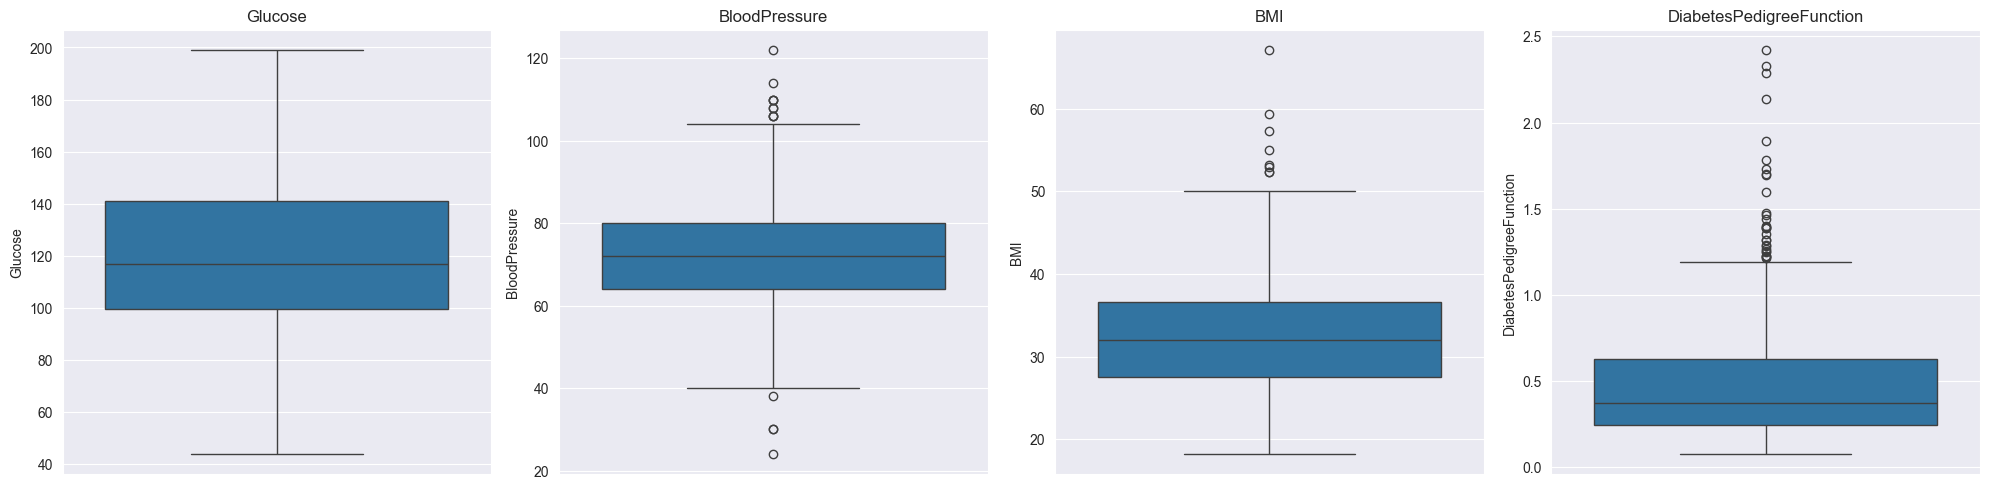

In [89]:
# Check for principal outliers in the data by view
params_list = ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
create_multi_plots(dia_ds1, params_list, 'boxplot', len(params_list))

There are some outliers in the columns 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction'. But they are not principal and can be left as is.

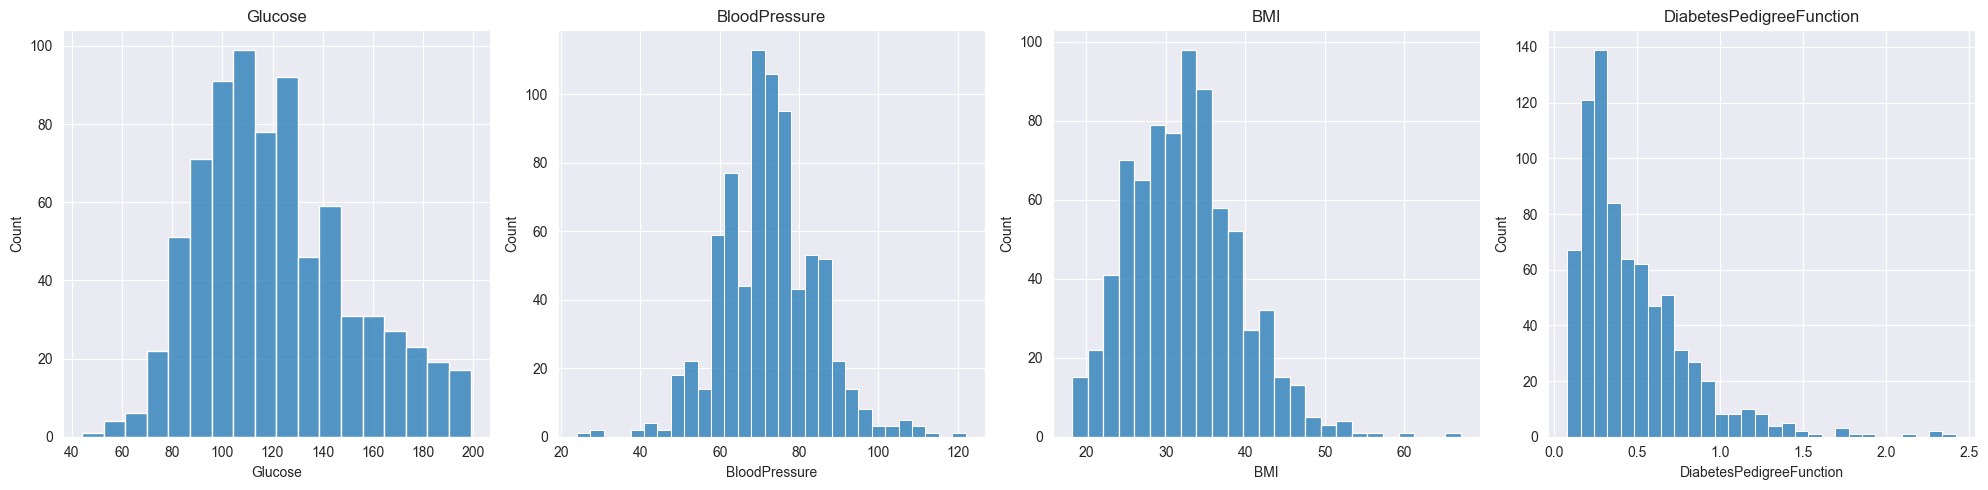

In [90]:
# Check the distribution of data to clarify norms and define what intervals to be suitable in future EDA
params_distribution_check = ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
create_multi_plots(dia_ds1, params_distribution_check, 'histplot', len(params_distribution_check))

The distribution of the data is normal. The intervals for the future EDA can be defined as follows:
- Glucose: 10
- BMI: 20
- BloodPressure: 10
- DiabetesPedigreeFunction: 10

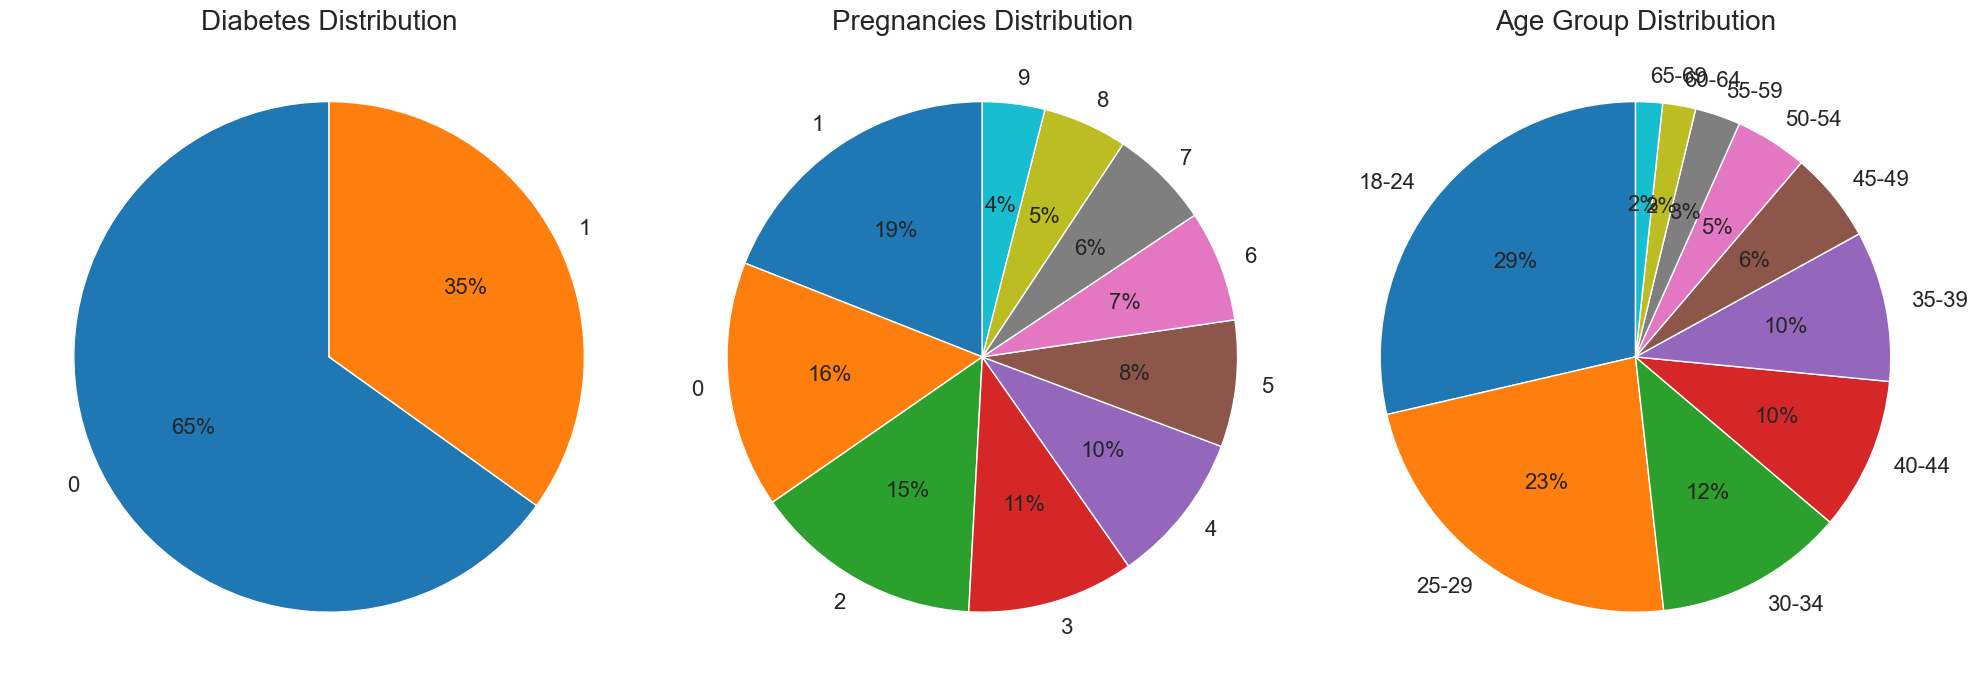

In [91]:
piecharts_cockpit(dia_ds1, ['Diabetes', 'Pregnancies', 'Age Group'])

The distribution of diabetes is not balanced. The distribution of pregnancies is also not balanced. The distribution of age groups is balanced.
2/3 of the dataset are women without diabetes.
Pregnancies are mostly in the range of 0-2.
The age groups are distributed evenly.

In [92]:
# Check the distribution of diabetes and prediabetes for each age group and number of pregnancies
params = ['Age Group', 'Pregnancies']
multiplot_one_bar_distribution(dia_ds1, params, 'Diabetes')

The distribution of diabetes and prediabetes is different for each age group. The distribution of diabetes and prediabetes is different for each number of pregnancies.
The most significant difference in the distribution of diabetes and prediabetes is observed in the age group 30-54.
The most significant difference in the distribution of diabetes and prediabetes is observed for the number of pregnancies 5+.

In [93]:
# Create a combined plot for Glucose and BMI
create_combined_plot(dia_ds1, 'Glucose', 'BMI')

The average values of Glucose and BMI are different for each age group.
The trend of BMI is similar to the trend of Glucose, but is less pronounced. Higher levelf glucose is in age range 50-69.

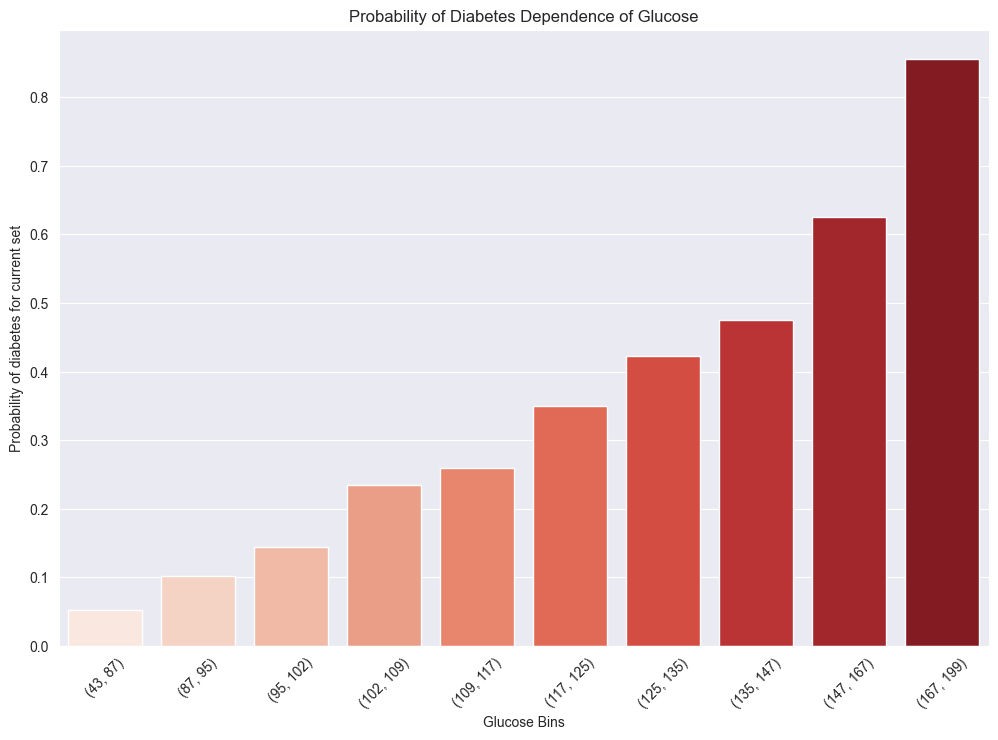

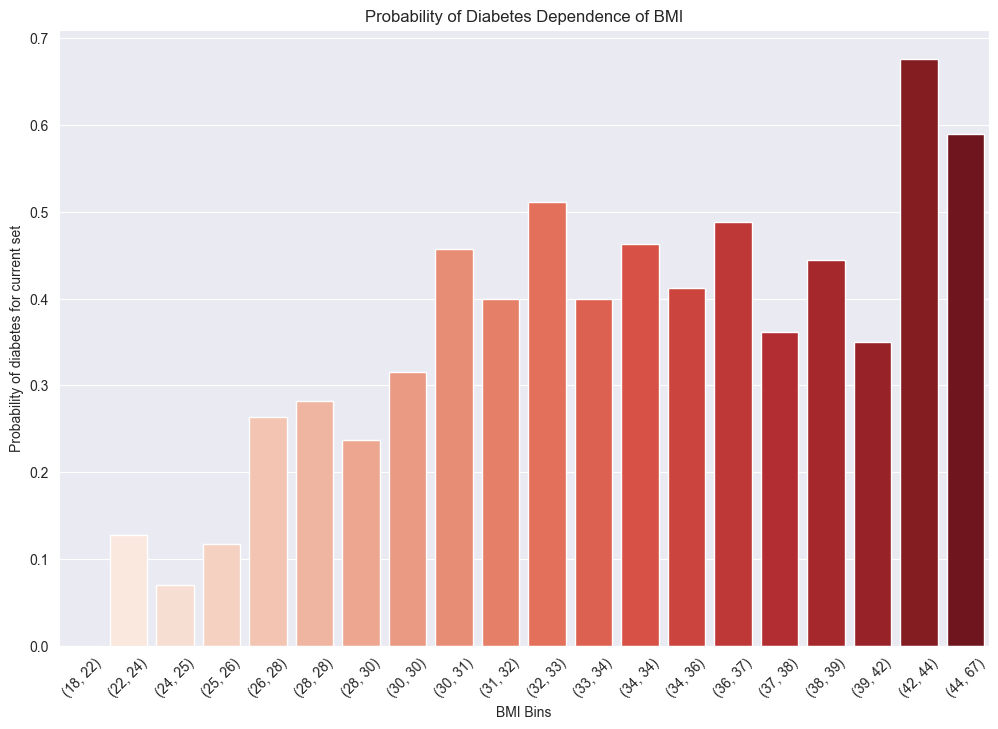

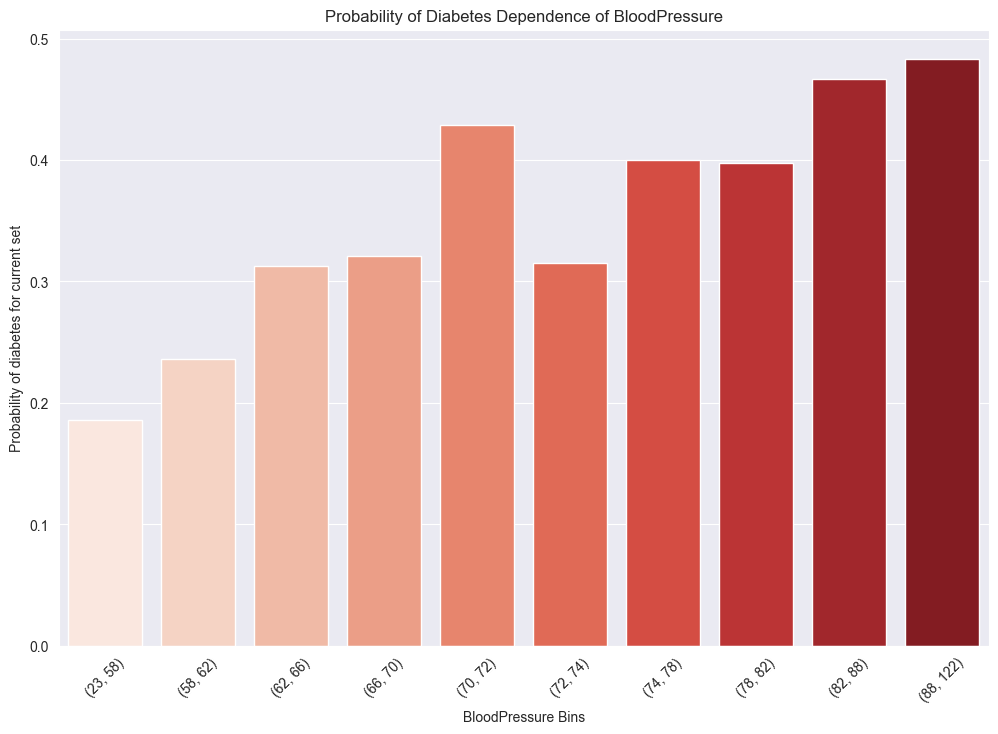

In [94]:
# Create a bar plot showing the probability of diabetes for each interval of Glucose, BMI and Blood Pressure
features_to_check = [('Glucose', 10), ('BMI', 20), ('BloodPressure', 10)]

for feature in features_to_check:
    title = 'Probability of Diabetes Dependence of ' + feature[0]
    dia_probability_by_binned_cat_barplot(dia_ds1, feature[0], 'Diabetes', feature[1], title)

The probability of diabetes is higher for higher levels of Glucose and BMI.
The probability of diabetes is higher for higher levels of Blood Pressure.
The critical values for Glucose are 135-140 , for BMI are 30-40, for Blood Pressure are 70-80.

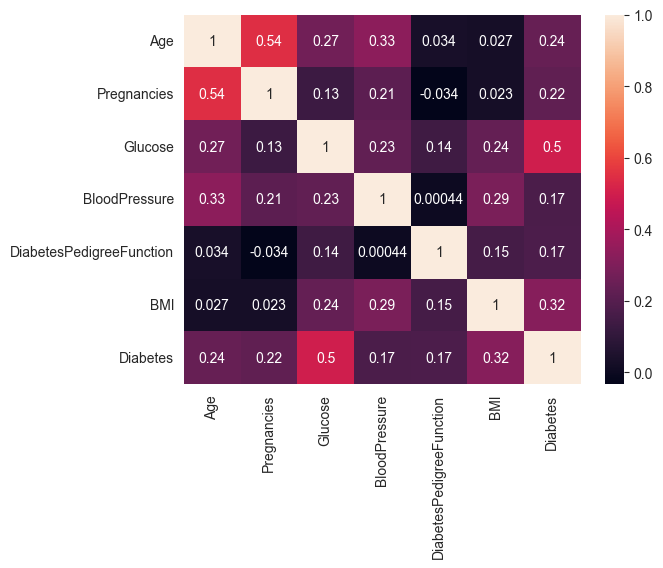

In [95]:
# Check the correlation between the features
features = ['Age', 'Pregnancies', 'Glucose', 'BloodPressure', 'DiabetesPedigreeFunction', 'BMI', 'Diabetes']

sns.heatmap(dia_ds1[features].corr(), annot=True)
plt.show()


The highest correlation with Diabetes is observed for Glucose and BMI.

The highest correlation with Glucose is observed for BMI.
The highest correlation with BMI is observed for Glucose.


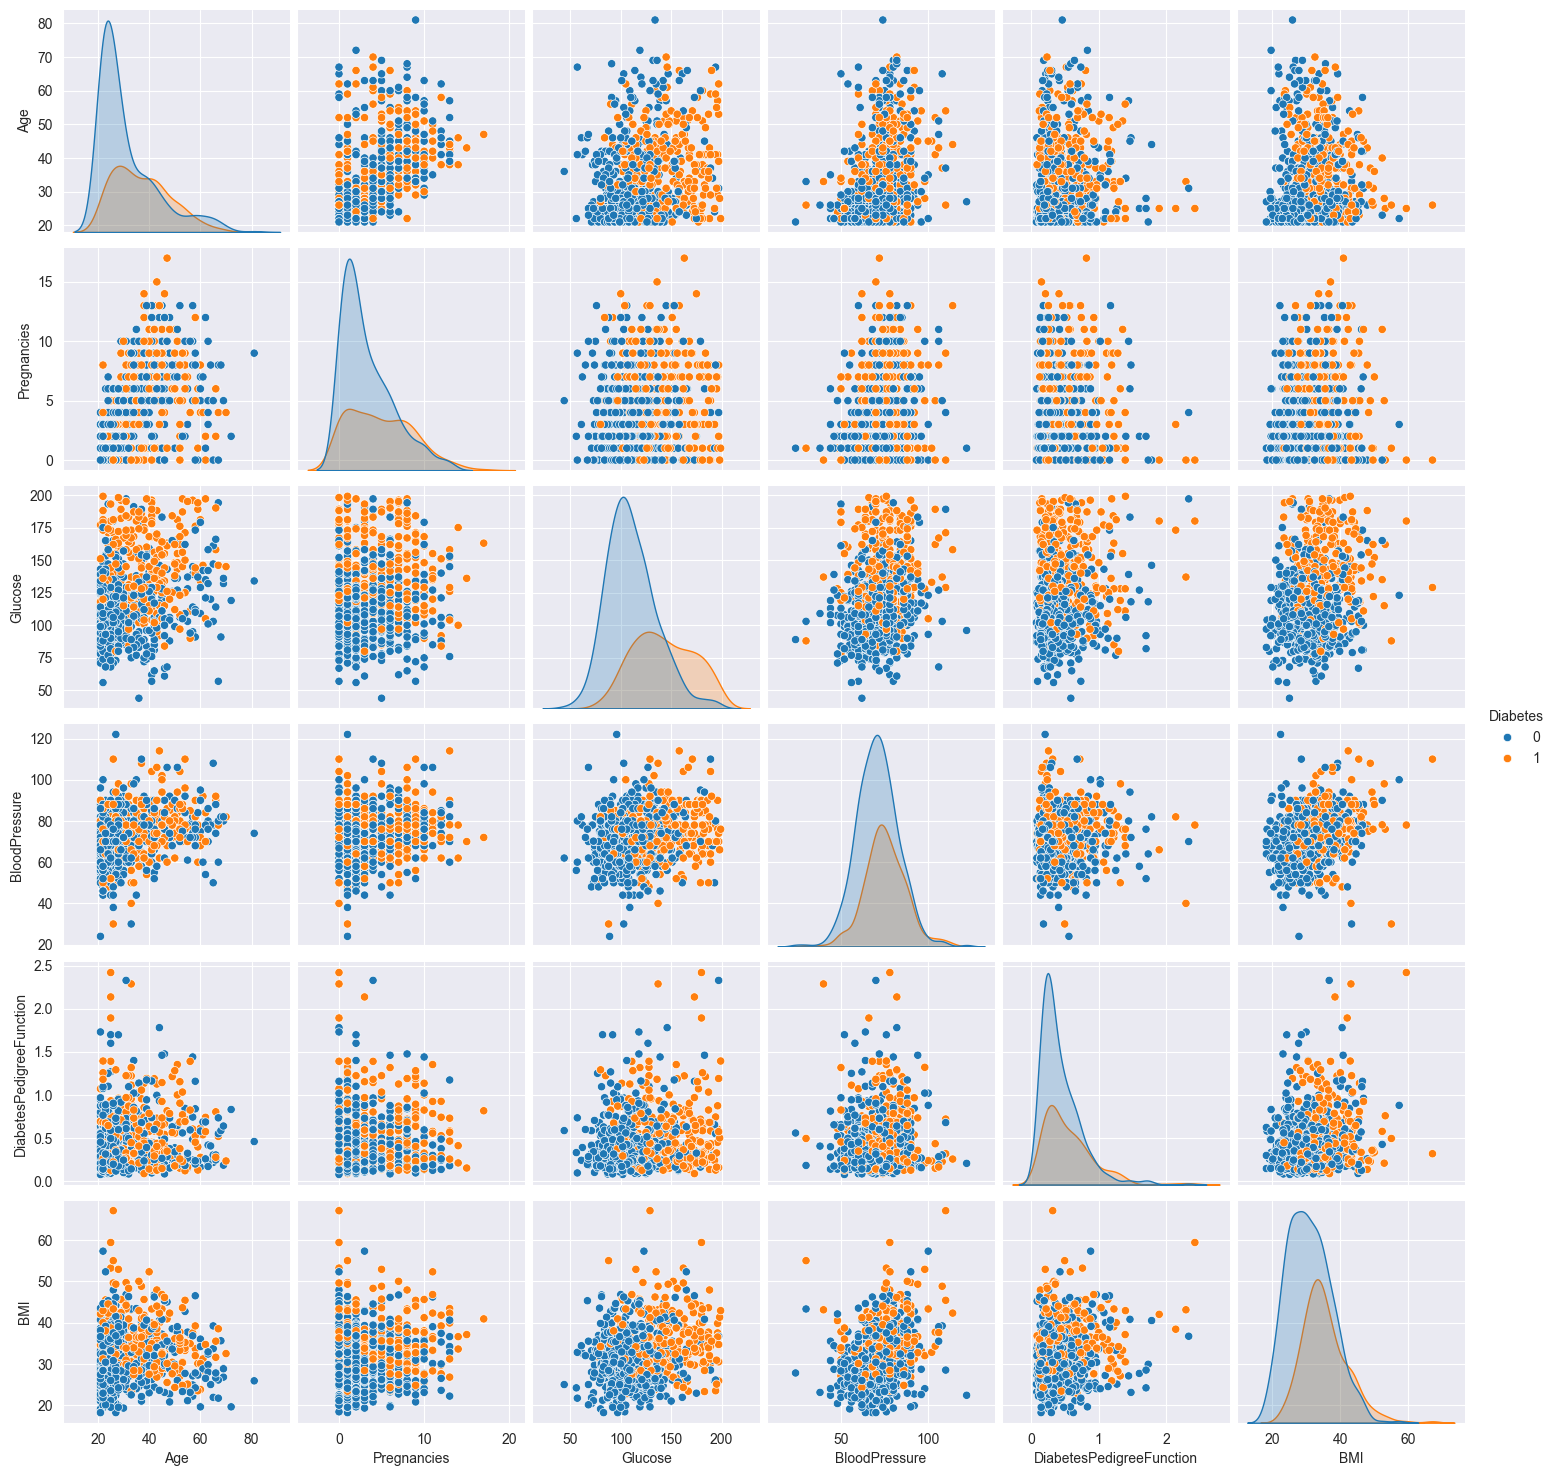

In [96]:
# Check the distribution of the features for each Diabetes value
sns.pairplot(dia_ds1[features], hue='Diabetes')
plt.show()

The distribution of the features is different for each Diabetes value.
Glucose and BMI are the most important features for predicting Diabetes.

Q1 (25th percentile) for Glucose when Diabetes = 1: 119.0
Q2 (50th percentile/median) for Glucose when Diabetes = 1: 140.5
Q3 (75th percentile) for Glucose when Diabetes = 1: 167.0


Q1 (25th percentile) for BMI when Diabetes = 1: 30.9
Q2 (50th percentile/median) for BMI when Diabetes = 1: 34.2
Q3 (75th percentile) for BMI when Diabetes = 1: 38.8


Q1 (25th percentile) for Age when Diabetes = 1: 28.0
Q2 (50th percentile/median) for Age when Diabetes = 1: 36.0
Q3 (75th percentile) for Age when Diabetes = 1: 44.0




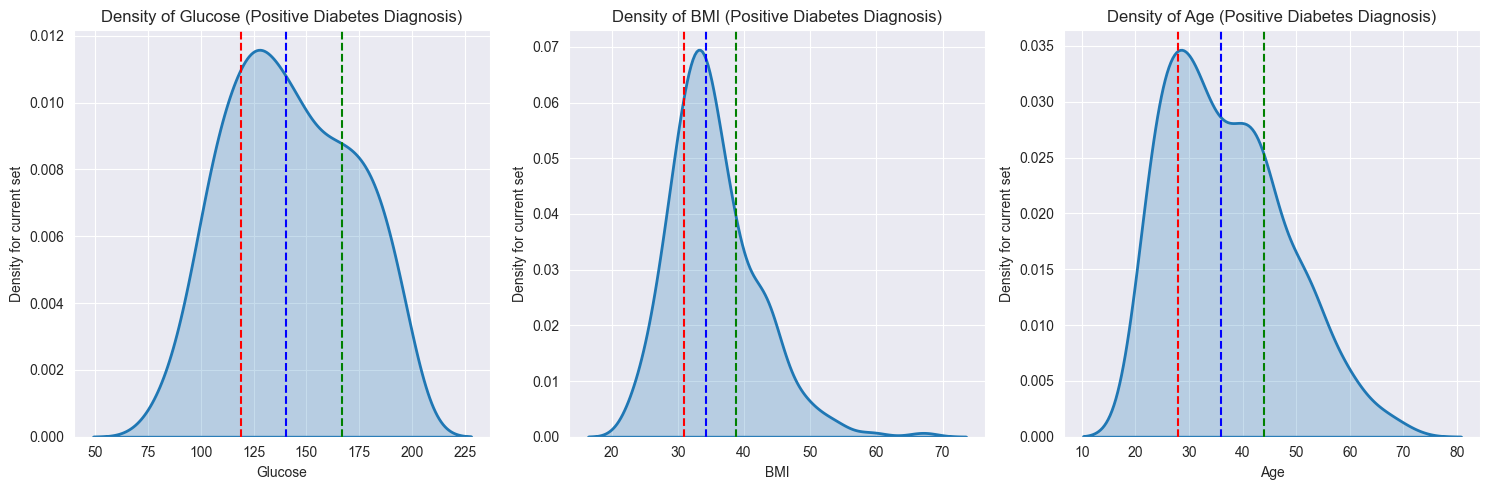

In [97]:
# Check the distribution of Glucose, BMI, and Age for each Diabetes value taking into account the 25th, 50th, and 75th percentiles
features = ['Glucose', 'BMI', 'Age']
plot_multiple_density_with_quantiles(dia_ds1, features, 'Diabetes')

The percentiles for Glucose, BMI, and Age are different for each Diabetes value.
The 25th percentile for Glucose is 100, for BMI is 30, for Age is 30.
The 50th percentile for Glucose is 125, for BMI is 35, for Age is 40.
The 75th percentile for Glucose is 150, for BMI is 40, for Age is 50.

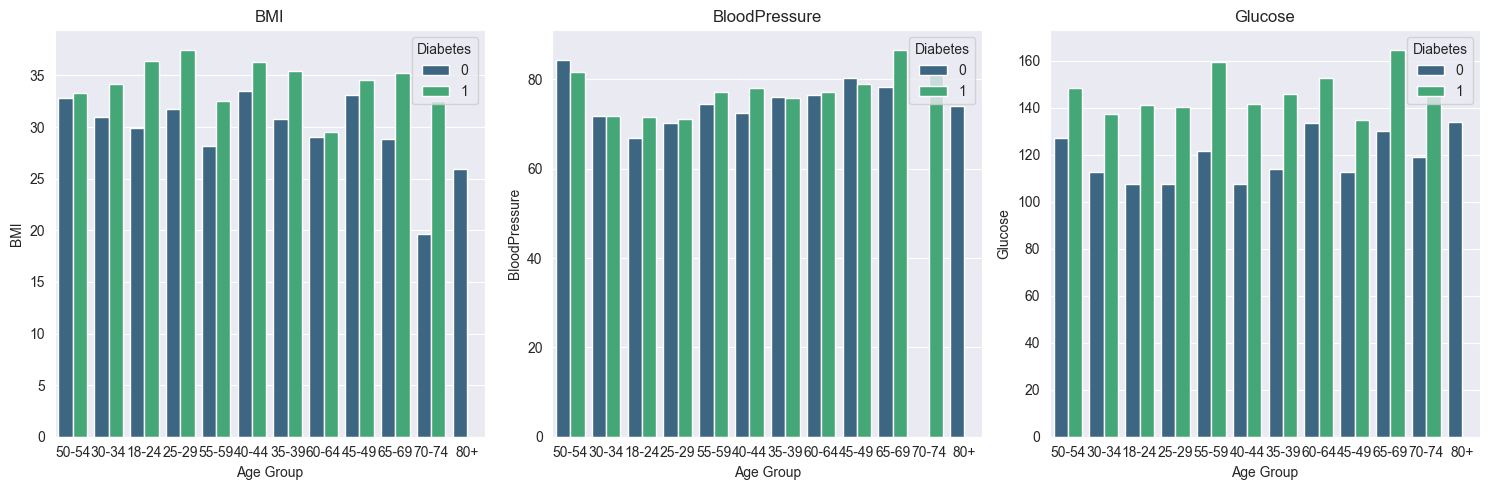

In [98]:
# Create a bar plot showing the average values of Glucose, Blood Pressure, and BMI for each age group with or without diabetes
columns_to_plot = ['BMI', 'BloodPressure', 'Glucose']
create_multi_barplots(dia_ds1, columns_to_plot, 'Age Group', 3)

In Age Group 18-24 the average values of Glucose, Blood Pressure, and BMI are higher for people with diabetes.
Glucose is the most important feature for predicting diabetes.

### 2nd dataset

In [99]:
# Cardiovascular Study Dataset EDA (file 1)
ds2_1 = pd.read_csv(diabetes_eda_project_sf_path + 'train.csv')
ds2_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

There are 3390 entries in the dataset with 16 columns. The dataset contains the following columns:
- id: ID
- age: Age of the patient
- education: 4 levels of education
- sex: sex of the patient
- is_smoking: smoking status
- cigsPerDay: number of cigarettes per day
- BPMeds: blood pressure medications
- prevalentStroke: history of stroke
- totChol: total cholesterol
- sysBP: systolic blood pressure
- diaBP: diastolic blood pressure
- BMI: Body mass index
- heartRate: heart rate
- glucose: glucose level
- TenYearCHD: 10-year risk of coronary heart disease (CHD) - the target variable

In [100]:
# Cardiovascular Study Dataset EDA (file 2)
ds2_2 = pd.read_csv(diabetes_eda_project_sf_path + 'test.csv')
ds2_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               848 non-null    int64  
 1   age              848 non-null    int64  
 2   education        830 non-null    float64
 3   sex              848 non-null    object 
 4   is_smoking       848 non-null    object 
 5   cigsPerDay       841 non-null    float64
 6   BPMeds           839 non-null    float64
 7   prevalentStroke  848 non-null    int64  
 8   prevalentHyp     848 non-null    int64  
 9   diabetes         848 non-null    int64  
 10  totChol          836 non-null    float64
 11  sysBP            848 non-null    float64
 12  diaBP            848 non-null    float64
 13  BMI              843 non-null    float64
 14  heartRate        848 non-null    float64
 15  glucose          764 non-null    float64
dtypes: float64(9), int64(5), object(2)
memory usage: 106.1+ KB


In [101]:
# Concatenate the datasets and drop duplicates
ds2_1 = ds2_1.drop(columns=['TenYearCHD', 'id'])
ds2_2 = ds2_2.drop(columns=['id'])

combined_ds2 = pd.concat([ds2_1, ds2_2])
dia_ds2 = combined_ds2.drop_duplicates()
dia_ds2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4238 entries, 0 to 847
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              4238 non-null   int64  
 1   education        4133 non-null   float64
 2   sex              4238 non-null   object 
 3   is_smoking       4238 non-null   object 
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
dtypes: float64(9), int64(4), object(2)
memory usage: 529.8+ KB


In [102]:
# Check either there is the lack of info as zeros or NaN values
define_zero_nan_percentage(dia_ds2)

Column age has 0.00% zeros and 0.00% NaNs
Column education has 0.00% zeros and 2.48% NaNs
      -> recommended to check expediency to fill the column education
Column sex has 0.00% zeros and 0.00% NaNs
Column is_smoking has 0.00% zeros and 0.00% NaNs
Column cigsPerDay has 50.59% zeros and 0.68% NaNs
      -> recommended to check expediency to drop the column cigsPerDay
Column BPMeds has 95.82% zeros and 1.25% NaNs
      -> recommended to check expediency to drop the column BPMeds
Column prevalentStroke has 99.41% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column prevalentStroke
Column prevalentHyp has 68.95% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column prevalentHyp
Column diabetes has 97.43% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column diabetes
Column totChol has 0.00% zeros and 1.18% NaNs
      -> recommended to check expediency to fill the column totChol
Column sysBP has 0.00% zeros

In [103]:
# Set Age Groups based on the Age distribution
dia_ds2['Age Group'] = pd.cut(dia_ds2['age'], bins=age_bins, labels=labels, right=False, include_lowest=True).astype('category')

In [104]:
# Fill NaN values in particular columns with the mean values of the corresponding group
dia_ds2 = fill_columns_with_mean(dia_ds2, ['education', 'totChol', 'BMI', 'heartRate', 'glucose', 'cigsPerDay', 'BPMeds'], value_to_fill=np.nan, index_col='diabetes')

In [105]:
dia_ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              4238 non-null   int64   
 1   education        4238 non-null   float64 
 2   sex              4238 non-null   object  
 3   is_smoking       4238 non-null   object  
 4   cigsPerDay       4238 non-null   float64 
 5   BPMeds           4238 non-null   float64 
 6   prevalentStroke  4238 non-null   int64   
 7   prevalentHyp     4238 non-null   int64   
 8   diabetes         4238 non-null   int64   
 9   totChol          4238 non-null   float64 
 10  sysBP            4238 non-null   float64 
 11  diaBP            4238 non-null   float64 
 12  BMI              4238 non-null   float64 
 13  heartRate        4238 non-null   float64 
 14  glucose          4238 non-null   float64 
 15  Age Group        4238 non-null   category
dtypes: category(1), float64(9), int64(4), obje

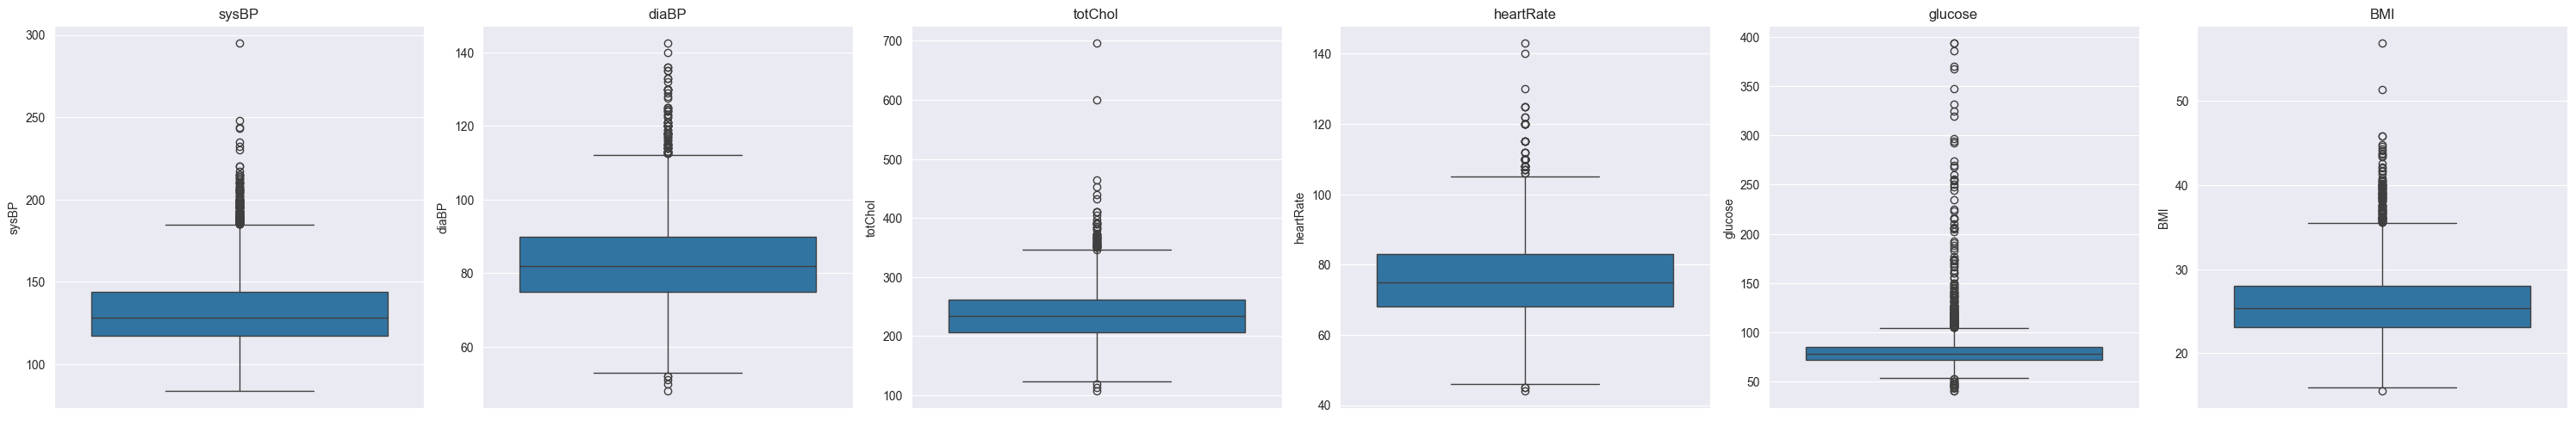

In [106]:
# Check the outliers in the data
params_list = ['sysBP', 'diaBP', 'totChol', 'heartRate', 'glucose', 'BMI']
create_multi_plots(dia_ds2, params_list, 'boxplot', len(params_list))

There are some outliers in the columns 'sysBP', 'diaBP', 'totChol', 'heartRate', 'BMI'. But they are not principal and can be left as is.

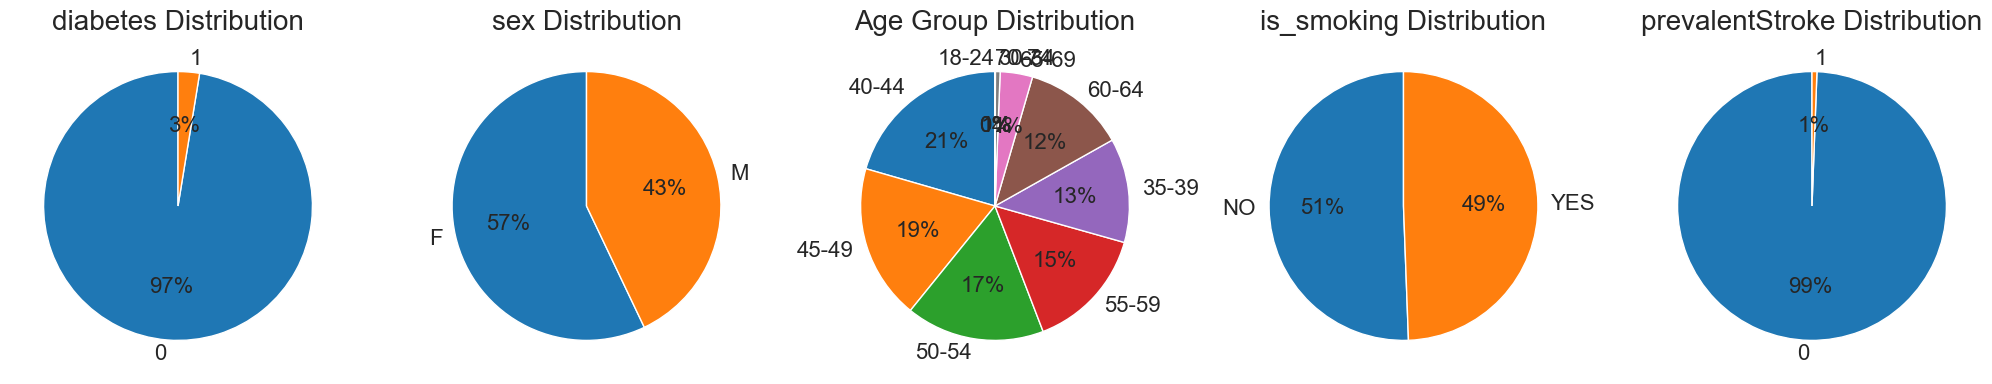

In [107]:
piecharts_cockpit(dia_ds2, ['diabetes', 'sex', 'Age Group', 'is_smoking', 'prevalentStroke'])

General characteristics of the dataset:
- diabetes is just 3% of the dataset
- sex distribution is balanced
- age groups are distributed evenly
- smoking status is balanced
- no stroke is 99% of the dataset

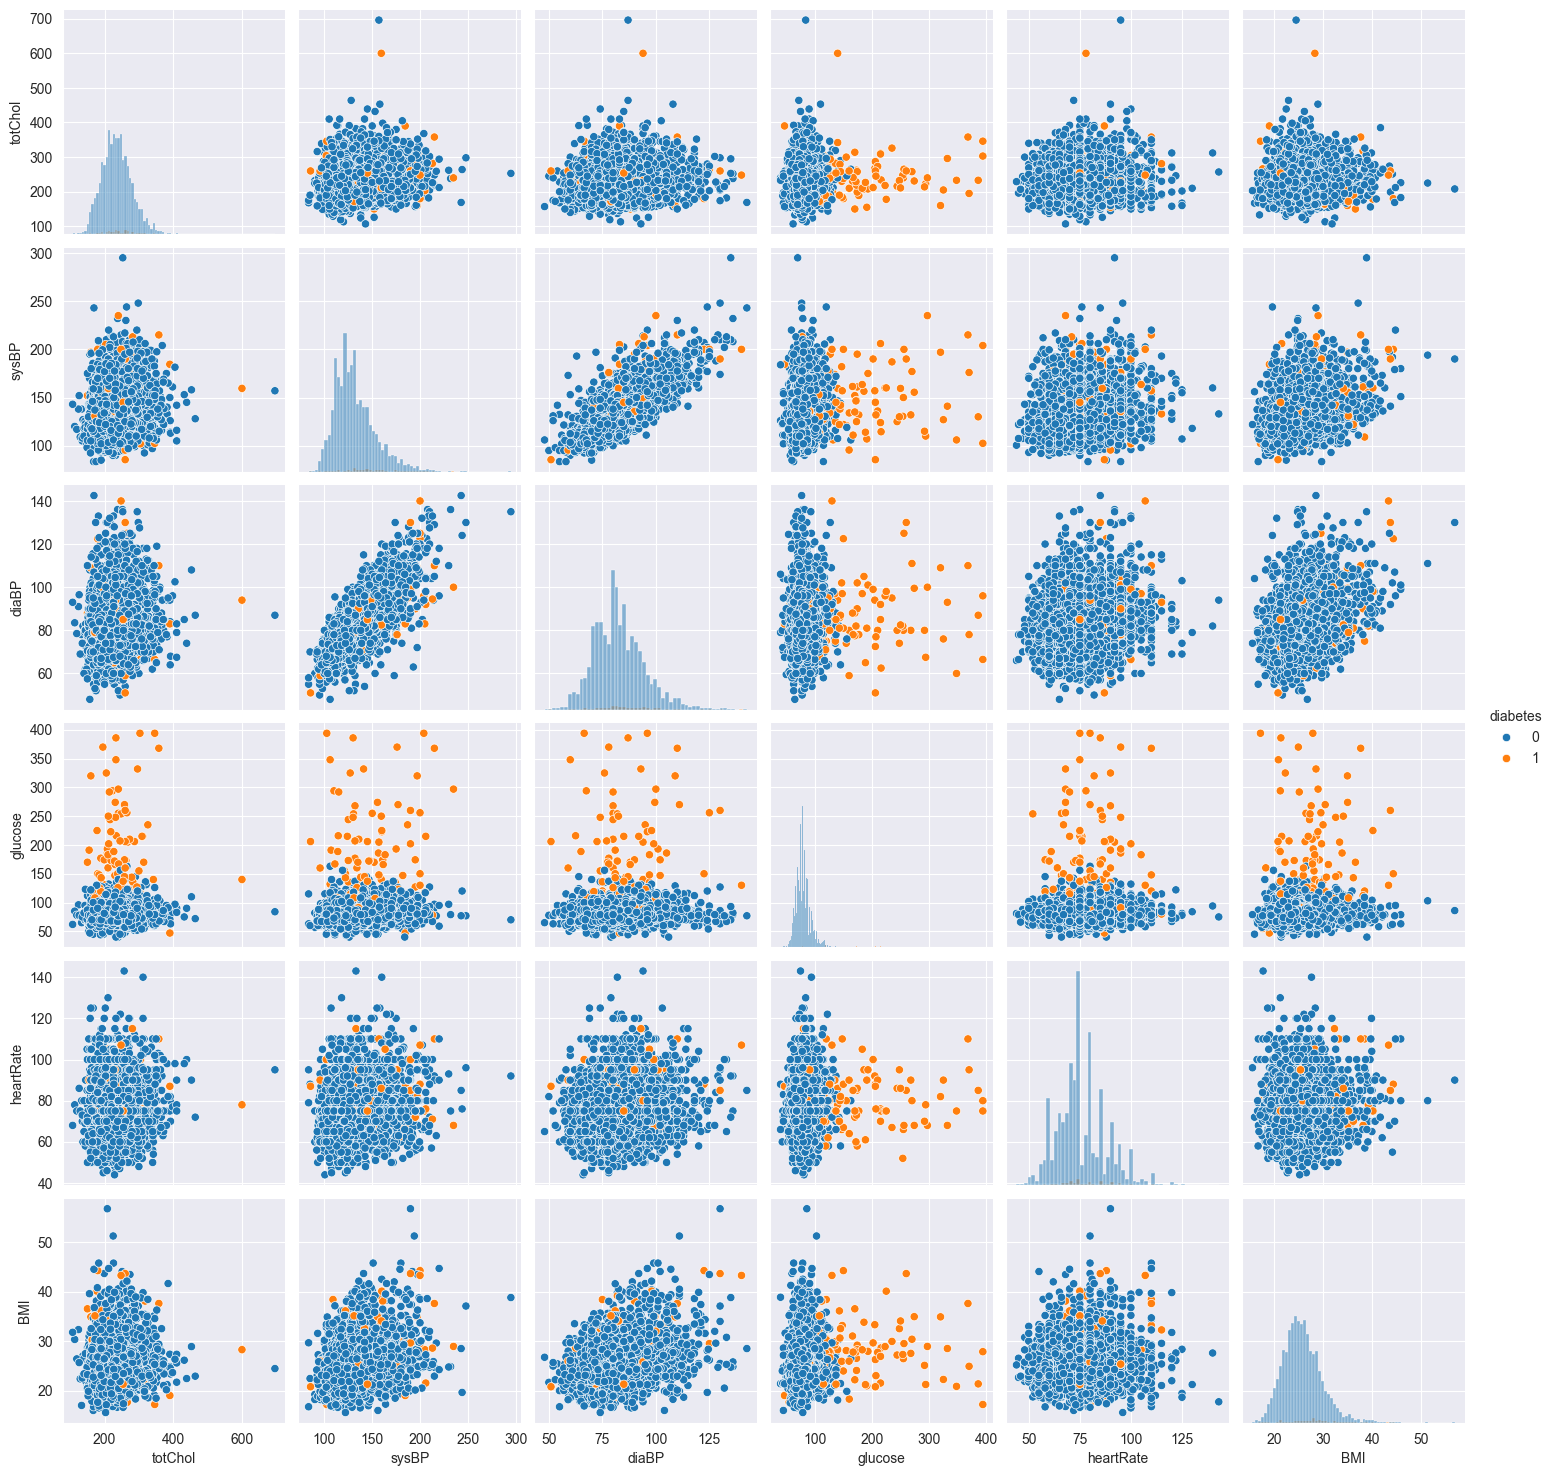

In [108]:
# Check the correlation between the features taking into account the diabetes value
params_list = ['totChol', 'sysBP', 'diaBP', 'glucose', 'heartRate', 'BMI', 'diabetes']

sns.pairplot(dia_ds2[params_list], diag_kind='hist', hue='diabetes')
plt.show()

Still the distribution of the features is different for each Diabetes value.
Still the highest correlation with Diabetes is observed for Glucose and BMI.
Still the highest correlation with Glucose is observed for BMI and vice versa.

In [109]:
dia_ds2['sex'] = dia_ds2['sex'].astype('category')

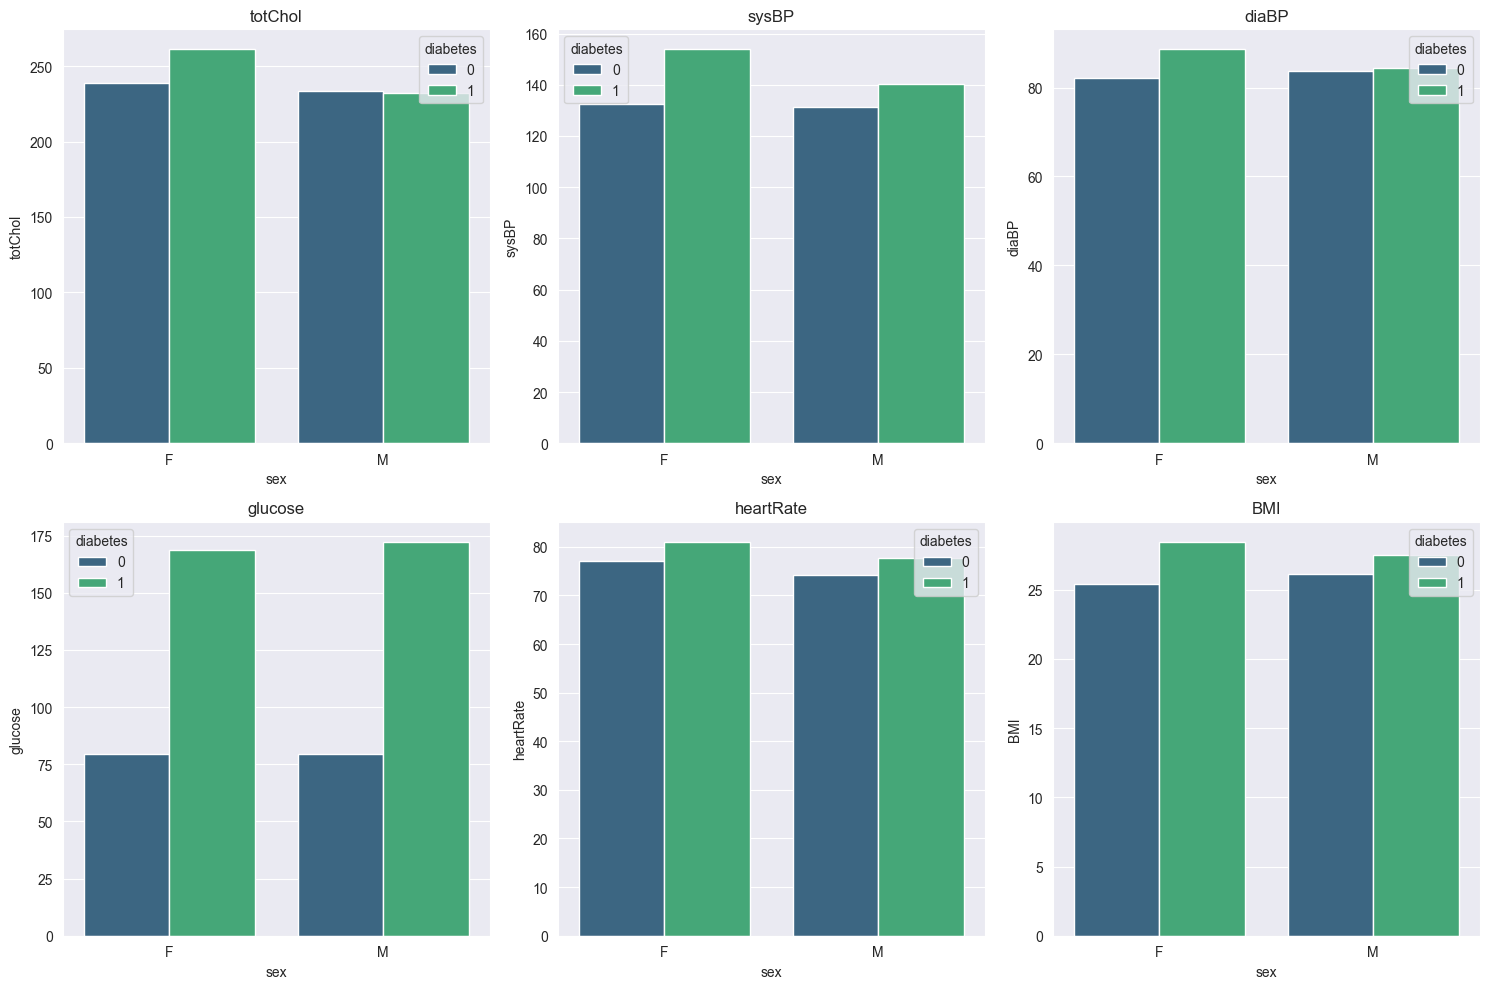

In [110]:
# Check the distribution of the features for each Diabetes value split by sex of patients
columns_to_plot = ['totChol', 'sysBP', 'diaBP','glucose', 'heartRate', 'BMI']
create_multi_barplots(dia_ds2, columns_to_plot, x_col='sex', charts_per_line=3, hue_index='diabetes')

The only difference is the level of systolic blood pressure and total cholesterol level. Difference for female with diabetes and without diabetes is more significant.

In [111]:
# Convert the features to format for visualization before concatenation with 1st dataset. Categories are defined based on the medical norms.
dia_ds2['HighBP'] = dia_ds2.apply(lambda row: 'high BP' if row['sysBP'] > 130 or row['diaBP'] > 80 else 'normal BP', axis=1)
dia_ds2['HighBP'] = dia_ds2['HighBP'].astype('category')

dia_ds2['HighChol'] = dia_ds2.apply(lambda row: 'high chol' if row['totChol'] > 240 else 'normal chol', axis=1)
dia_ds2['HighChol'] = dia_ds2['HighChol'].astype('category')

NEW_COLUMNS_DS2 = {
    'age': 'Age',
    'sex': 'Sex',
    'is_smoking': 'Smoker',
    'cigsPerDay': 'CigarettesPerDay',
    'prevalentStroke': 'Stroke',
    'diabetes': 'Diabetes',
    'glucose': 'Glucose'
}                      
dia_ds2.rename(columns=NEW_COLUMNS_DS2, inplace=True)

dia_ds2['Stroke'] = dia_ds2['Stroke'].apply(lambda x: 'no stroke' if x == 0 else 'stroke')
                         
params_categorized = ['Sex', 'Smoker', 'Stroke', 'Diabetes', 'HighBP', 'HighChol']                        
dia_ds2[params_categorized] = dia_ds2[params_categorized].astype('category')

In [112]:
dia_ds1 ['Sex'] = 'F'

params_categorized = ['Diabetes', 'Age Group', 'Sex']
dia_ds1[params_categorized] = dia_ds1[params_categorized].astype('category')
dia_ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               4238 non-null   int64   
 1   education         4238 non-null   float64 
 2   Sex               4238 non-null   category
 3   Smoker            4238 non-null   category
 4   CigarettesPerDay  4238 non-null   float64 
 5   BPMeds            4238 non-null   float64 
 6   Stroke            4238 non-null   category
 7   prevalentHyp      4238 non-null   int64   
 8   Diabetes          4238 non-null   category
 9   totChol           4238 non-null   float64 
 10  sysBP             4238 non-null   float64 
 11  diaBP             4238 non-null   float64 
 12  BMI               4238 non-null   float64 
 13  heartRate         4238 non-null   float64 
 14  Glucose           4238 non-null   float64 
 15  Age Group         4238 non-null   category
 16  HighBP            4238 n

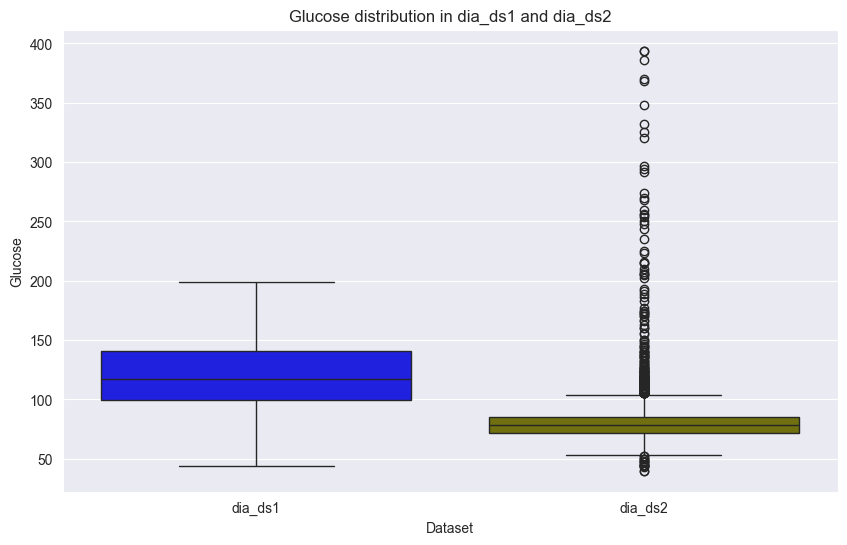

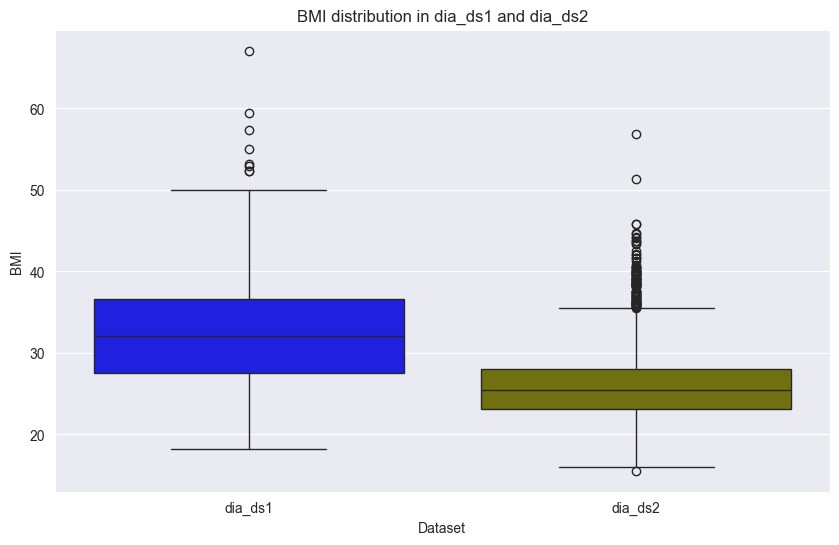

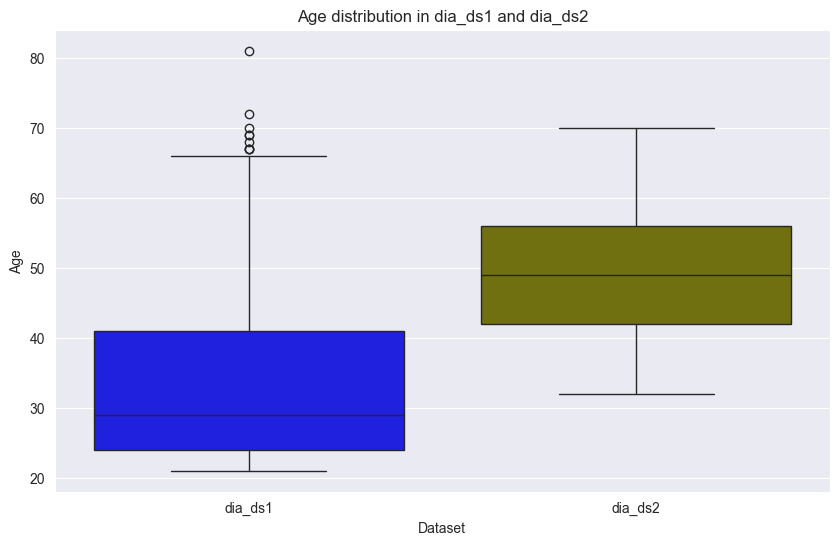

In [113]:
# Compare the distribution of the features in the datasets 1 and 2 before concatenation
params_compared = ['Glucose', 'BMI', 'Age']

for param in params_compared:

    index1 = dia_ds1[param]
    index2 = dia_ds2[param]
    data = pd.concat([pd.DataFrame({param: index1, 'Dataset': 'dia_ds1'}),
                      pd.DataFrame({param: index2, 'Dataset': 'dia_ds2'})])
    
    palette = {"dia_ds1": "blue", "dia_ds2": "olive"}
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Dataset', y=param, data=data, palette=palette)
    plt.title(f'{param} distribution in dia_ds1 and dia_ds2')
    plt.show()

The distribution of the features in the datasets 1 and 2 is different.
We will change not only proportions but also the distribution of the features, especially increasing age range. 

### Concatenation of datasets 1-2 (common features)

In [114]:
# Find the common columns
common_columns = list(set(dia_ds1.columns).intersection(set(dia_ds2.columns)))
# Concatenate along the rows of common columns only.
dia_ds12 = pd.concat([dia_ds1[common_columns], dia_ds2[common_columns]], axis=0)
dia_ds12.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5006 entries, 0 to 4237
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BMI        5006 non-null   float64 
 1   Glucose    5006 non-null   float64 
 2   Sex        5006 non-null   object  
 3   Diabetes   5006 non-null   category
 4   Age Group  5006 non-null   object  
 5   Age        5006 non-null   int64   
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 239.7+ KB


In [115]:
# Diabetes distribution in the concatenated dataset
group_cols =['Age Group']
multiplot_one_bar_distribution(dia_ds12, group_cols, 'Diabetes')

The distribution of diabetes and prediabetes is different for each age group. Age groups are principally different in terms of patient number

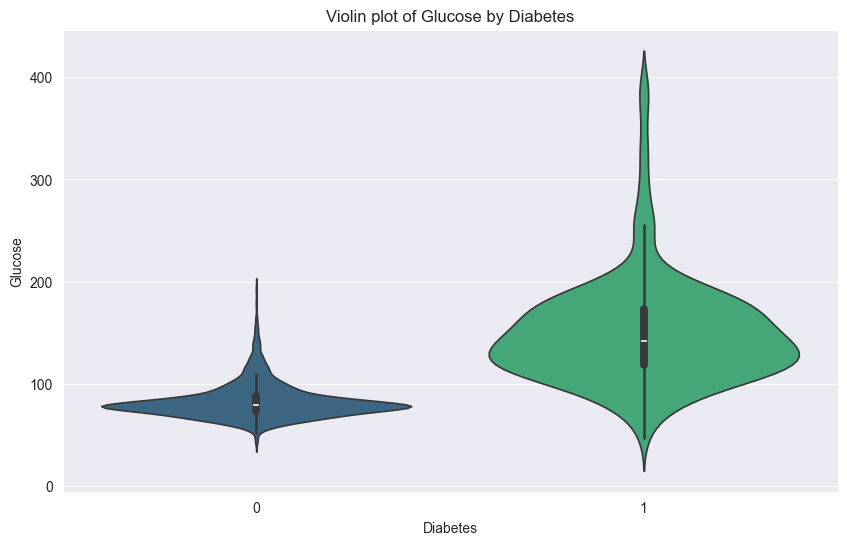

In [116]:
# Usage of violin plot will give more detailed information about the distribution of Glucose by Diabetes.
plt.figure(figsize=(10, 6))
sns.violinplot(x='Diabetes', y='Glucose', data=dia_ds12, palette='viridis')
plt.title('Violin plot of Glucose by Diabetes')
plt.show()

The distribution of Glucose is different for each Diabetes value. The distribution of Glucose is wider for people with diabetes.
Important values for Glucose are 100-125 for people without diabetes and 125-150 for people with diabetes.
Also it is valuable to mention next figures: 75th percentile for Glucose is 125 for people without diabetes and 150 for people with diabetes.

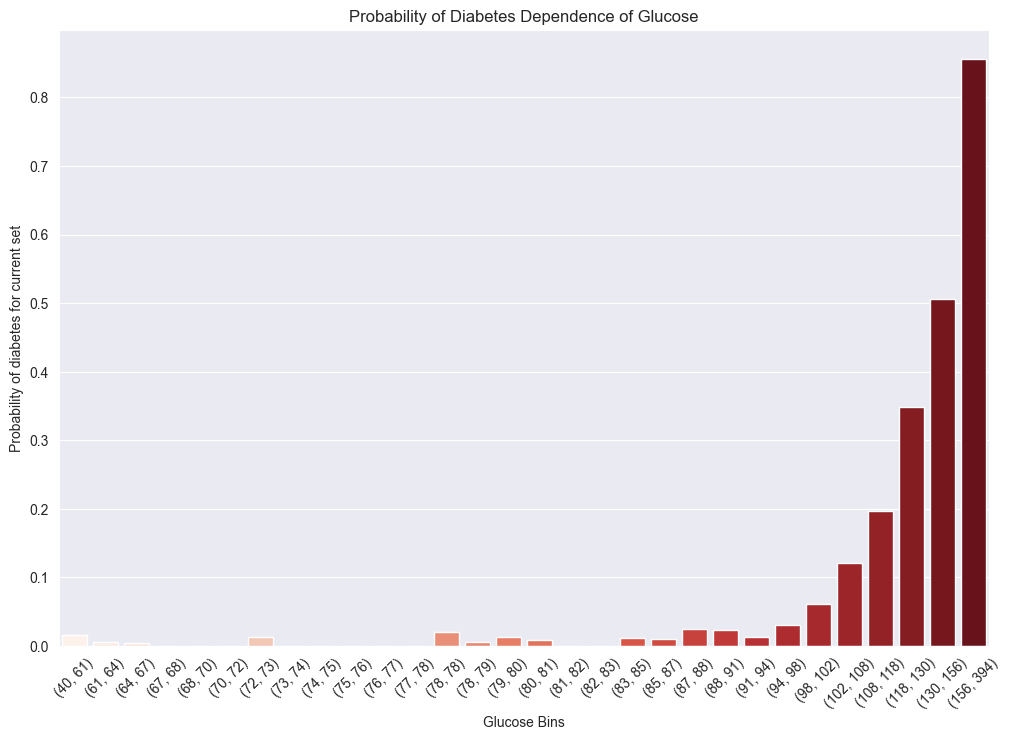

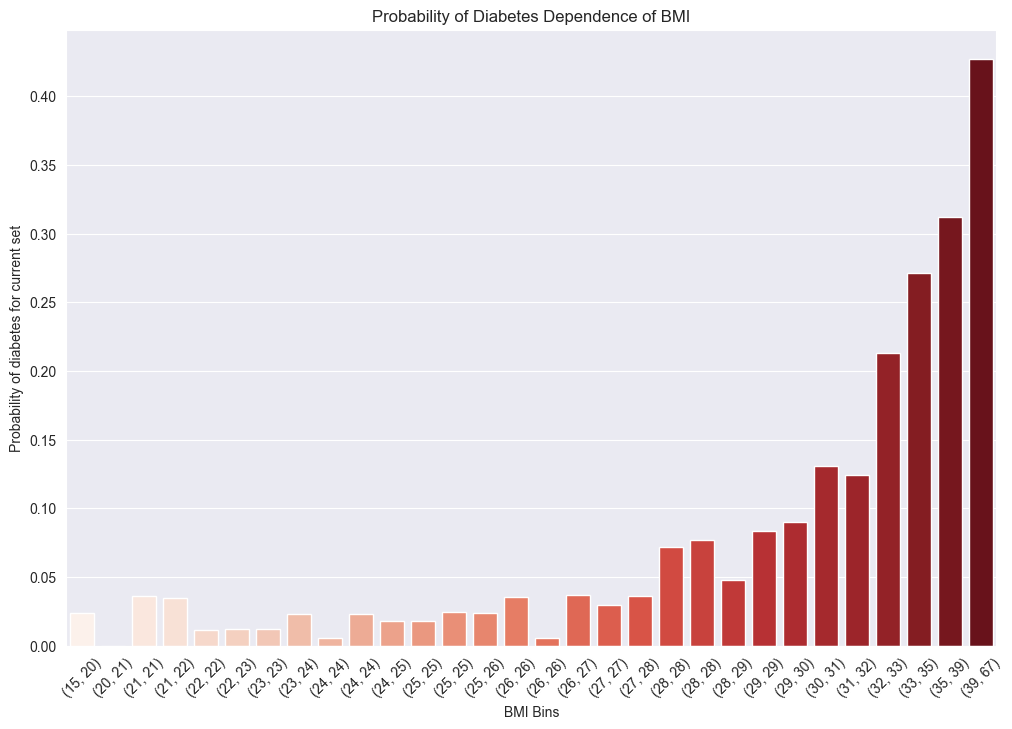

In [117]:
# Probability of diabetes for each interval of Glucose and BMI (define the critical level)
features_to_check = [('Glucose', 30), ('BMI', 30)]

for feature in features_to_check:
    title = 'Probability of Diabetes Dependence of ' + feature[0]
    dia_probability_by_binned_cat_barplot(dia_ds12, feature[0], 'Diabetes', feature[1], title)

The probability of diabetes is higher for higher levels of Glucose and BMI.
The critical values for Glucose are 125-150, for BMI are 30-35.


## 3rd dataset

In [118]:
dia_ds3 = pd.read_csv(diabetes_eda_project_sf_path + 'diabetes_012_health_indicators_BRFSS2015.csv')
dia_ds3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

There are 253680 entries in the dataset with 17 columns. The dataset contains the following columns:
- Diabetes_012: Diabetes status (0 - no diabetes, 1 - prediabetes, 2 - diabetes)
- Age: Age of the patient
- GenHlth: General health status
- PhysHlth: Physical health status
- MentHlth: Mental health status
- HighBP: High blood pressure
- HighChol: High cholesterol
- Stroke: Stroke
- CholCheck: Cholesterol check in the last 5 years
- Smoker: Smoking status
- HeartDiseaseorAttack: Coronary heart disease or heart attack
- PhysActivity: Physical activity in the last 30 days
- Fruits: Fruits consumption
- Veggies: Vegetables consumption
- HvyAlcoholConsump: Heavy alcohol consumption
- AnyHealthcare: Health care coverage
- NoDocbcCost: Money issues for ambulance
- DiffWalk: Walking difficulty

In [119]:
# Check either there is the lack of info as zeros or NaN values
define_zero_nan_percentage(dia_ds3)

Column Diabetes_012 has 84.24% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column Diabetes_012
Column HighBP has 57.10% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column HighBP
Column HighChol has 57.59% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column HighChol
Column CholCheck has 3.73% zeros and 0.00% NaNs
      -> recommended to check expediency to fill the column CholCheck
Column BMI has 0.00% zeros and 0.00% NaNs
Column Smoker has 55.68% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column Smoker
Column Stroke has 95.94% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column Stroke
Column HeartDiseaseorAttack has 90.58% zeros and 0.00% NaNs
      -> recommended to check expediency to drop the column HeartDiseaseorAttack
Column PhysActivity has 24.35% zeros and 0.00% NaNs
Column Fruits has 36.57% zeros and 0.00% NaNs
      -> recommended

In [120]:
# Convert prediabetes and diabetes to one binary value (in accordance with other datasets
dia_ds3['Diabetes'] = dia_ds3['Diabetes_012'].apply(lambda x: 0 if x == 0 else 1)
dia_ds3.drop(['Diabetes_012'], axis=1, inplace=True)

In [121]:
# Prepare the data of dataset for visualization (categorize the data)
def map_values(df, column, pos_value, neg_value):
    df[column] = df[column].apply(lambda x: neg_value if x == 0 else pos_value)
    return df

FIELDS_MAPPING_DICT = {
    'HighBP': ('high BP', 'normal BP'),
    'HighChol': ('high chol', 'normal chol'),
    'Stroke': ('stroke', 'no stroke'),
    'CholCheck': ('chol check in 5 years', 'no chol check in 5 years'),
    'Smoker': ('100+ cigarettes in life', 'non smoker'),
    'HeartDiseaseorAttack': ('CHD or MI', 'no CHD or MI'),
    'PhysActivity': ('phys activity in 30d', 'no phys activity in 30d'),
    'Fruits': ('fruits daily', 'no fruits daily'),
    'Veggies': ('veggies daily', 'no veggies daily'),
    'HvyAlcoholConsump': ('heavy drinkers', 'non heavy drinkers'),
    'AnyHealthcare': ('health care coverage', 'no health care coverage'),
    'NoDocbcCost': ('money issue for ambulance', 'no money issues for ambulance'),
    'DiffWalk': ('walk difficulty', 'no walk difficulty'),
    'Sex': ('M', 'F')
}
HEALTH_RATINGS = {
    1: '1 - excellent',
    2: '2 - very good',
    3: '3 - good',
    4: '4 - fair',
    5: '5 - poor'
}
INCOME_RATINGS = {
    1: '1 < 10k USD',
    2: '2 ...',
    3: '3 ...',
    4: '4 ...',
    5: '5 < 35k USD',
    6: '6 ...',
    7: '7 ...',
    8: '8 > 75k USD'
}
AGE_BINS = {
    1: '18-24',
    2: '25-29',
    3: '30-34',
    4: '35-39',
    5: '40-44',
    6: '45-49',
    7: '50-54',
    8: '55-59',
    9: '60-64',
    10: '65-69',
    11: '70-74',
    12: '75-79',
    13: '80+'
}

dia_ds3.rename(columns={'Diabetes_binary': 'Diabetes', 'Age': 'Age Group'}, inplace=True)

for field, (pos_val, neg_val) in FIELDS_MAPPING_DICT.items():
    dia_ds3 = map_values(dia_ds3, field, pos_val, neg_val)

dia_ds3['GenHlth'] = dia_ds3['GenHlth'].replace(HEALTH_RATINGS)
dia_ds3['Income'] = dia_ds3['Income'].replace(INCOME_RATINGS)
dia_ds3['Age Group'] = dia_ds3['Age Group'].replace(AGE_BINS)

In [122]:
params_to_categorized = ['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                      'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
                      'GenHlth', 'DiffWalk', 'Sex', 'Age Group', 'Education', 'Income']
params_to_int = ['PhysHlth', 'MentHlth']

dia_ds3[params_to_categorized] = dia_ds3[params_to_categorized].astype('category')
dia_ds3[params_to_int] = dia_ds3[params_to_int].astype(int)

In [123]:
dia_ds3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HighBP                253680 non-null  category
 1   HighChol              253680 non-null  category
 2   CholCheck             253680 non-null  category
 3   BMI                   253680 non-null  float64 
 4   Smoker                253680 non-null  category
 5   Stroke                253680 non-null  category
 6   HeartDiseaseorAttack  253680 non-null  category
 7   PhysActivity          253680 non-null  category
 8   Fruits                253680 non-null  category
 9   Veggies               253680 non-null  category
 10  HvyAlcoholConsump     253680 non-null  category
 11  AnyHealthcare         253680 non-null  category
 12  NoDocbcCost           253680 non-null  category
 13  GenHlth               253680 non-null  category
 14  MentHlth              253680 non-nul

In [124]:
# Define the most important parameters for correlation with diabetes diagnosis
GROUP_COLUMNS = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
                 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk',
                 'Sex', 'Age Group', 'Education', 'Income']

multiplot_one_bar_distribution(dia_ds3, GROUP_COLUMNS, 'Diabetes')

The distribution of diabetes and prediabetes is different for each group in the specified columns.
Going category by category:
- High dialistical blood pressure is more common for people with diabetes (27% vs 7% with normal diaBP) - critical parameter
- High cholesterol is more common for people with diabetes (25% vs 9% with normal chol) - critical parameter
- Smokers have more risk of diabetes (18% vs 14%), but not critically
- People with diabetes have more often stroke history (34% vs 15%)
- People with diabetes have more often heart disease or attack history (36% vs 14%)
- Physical activities, eating fruites and vegetables helps to decrease the risk of diabetes
- Heavy alcohol consumption is not critical for diabetes
- Health care coverage is not critical for diabetes
- Money issues for ambulance is not critical for diabetes
- General health status is critical for diabetes (fair - 34%, poor - 40%)
- Walking difficulty is critical characteristic for diabetes
- High education and income usually decrease the risk of diabetes (as factors of healthy life style)

### Concatenated dataset 2-3

In [125]:
# Find the common columns
common_columns = list(set(dia_ds2.columns).intersection(set(dia_ds3.columns)))
# Concatenate along the rows of common columns only.
dia_ds23 = pd.concat([dia_ds2[common_columns], dia_ds3[common_columns]], axis=0)

In [126]:
dia_ds23.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257918 entries, 0 to 253679
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   BMI        257918 non-null  float64 
 1   Smoker     257918 non-null  object  
 2   Sex        257918 non-null  object  
 3   HighBP     257918 non-null  object  
 4   Stroke     257918 non-null  object  
 5   Diabetes   257918 non-null  category
 6   Age Group  257918 non-null  object  
 7   HighChol   257918 non-null  object  
dtypes: category(1), float64(1), object(6)
memory usage: 16.0+ MB


In [127]:
GROUP_COLUMNS = ['HighChol', 'HighBP', 'Stroke']
dia_ds23[GROUP_COLUMNS] = dia_ds23[GROUP_COLUMNS].astype('category')
multiplot_one_bar_distribution(dia_ds23, GROUP_COLUMNS, 'Diabetes')

The distribution of diabetes and prediabetes is different for each group in the specified columns.
Going category by category:
- High cholesterol is more common for people with diabetes (24% vs 9% with normal chol) - critical parameter
- High dialistical blood pressure is more common for people with diabetes (27% vs 7% with normal diaBP) - critical parameter
- People with diabetes have more often stroke history (34% vs 15%)

### Concatenated dataset 1-2-3

In [128]:
common_columns = list(set(dia_ds12.columns).intersection(set(dia_ds3.columns)))
# Concatenate along the rows of common columns only.
dia_ds123 = pd.concat([dia_ds12[common_columns], dia_ds3[common_columns]], axis=0)

dia_ds123[['Sex', 'Age Group']] = dia_ds123[['Sex', 'Age Group']].astype('category')

In [129]:
dia_ds123.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258686 entries, 0 to 253679
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   Diabetes   258686 non-null  int64   
 1   BMI        258686 non-null  float64 
 2   Sex        258686 non-null  category
 3   Age Group  258686 non-null  category
dtypes: category(2), float64(1), int64(1)
memory usage: 6.4 MB


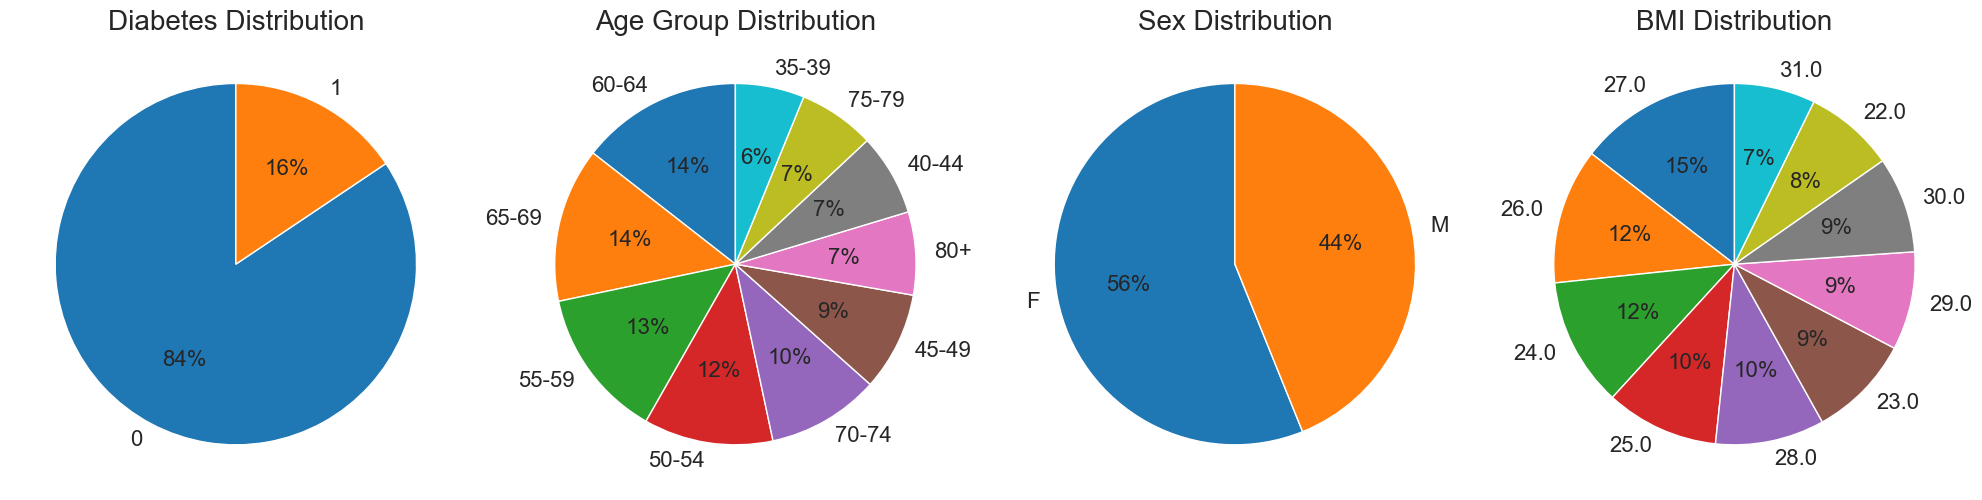

In [130]:
# General information about the concatenated dataset
piecharts_cockpit(dia_ds123, ['Diabetes', 'Age Group', 'Sex', 'BMI'])

General characteristics of the dataset:
- diabetes is 16% of the total dataset
- age groups are distributed evenly
- sex distribution is balanced
- BMI is distributed evenly